# Q1 - Analyzing Retail Fuel Price Dynamics in New South Wales (2016–2025)
Retail fuel prices in New South Wales often exhibit pronounced price cycles:
sharp increases followed by gradual declines. In this coursework you will clean
a retail fuel dataset and build a simple forecasting model that predicts next-day
prices for each fuel type sold at that different fuel stations
## Q1.1 - Data cleaning and Visualization

### Q1.1(i) - Cleaning and Summary **[1 mark]**
Report a short summary (rows before/after; date range; list of distinct FuelCodes;
missing values handled) after:
- Parsing PriceUpdatedDate into date/time; ensuring Price is numeric
(cents per litre).
- Removing exact duplicates; dropping implausible prices (state a simple
valid range and justify).
- Aggregating to a daily table per fuel: for each (FuelCode, date) compute the daily minimum price.

In [2]:
# import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,date
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

# read csv data
df = pd.read_csv("fuelPrice_NSW.csv")
#check size of data set
print(df.shape)
# view the csv
df


(98925, 6)


,ServiceStationName,FuelCode,PriceUpdatedDate,Price,Latitude,Longitude
0,7-Eleven Minchinbury,E10,2025-08-31 22:10:00,159.9,-33.778213,150.808089
1,7-Eleven Minchinbury,U91,2025-08-31 22:10:00,163.9,-33.778213,150.808089
2,7-Eleven Minchinbury,P95,2025-08-31 22:10:00,178.9,-33.778213,150.808089
3,7-Eleven Minchinbury,P98,2025-08-31 22:10:00,185.9,-33.778213,150.808089
4,7-Eleven Blacktown,P98,2025-08-31 18:44:00,188.9,-33.754838,150.891467
...,...,...,...,...,...,...
98920,7-Eleven Croydon Park,P98,2016-08-01 00:28:00,121.9,-33.894219,151.111471
98921,7-Eleven Croydon Park,U91,2016-08-01 00:28:00,105.9,-33.897687,151.099818
98922,7-Eleven Croydon Park,P98,2016-08-01 00:28:00,121.9,-33.897687,151.099818
98923,7-Eleven Croydon Park,P95,2016-08-01 00:28:00,116.9,-33.894219,151.111471


In [3]:
# turn the priceUpdatedDate into a datetime data type
df['PriceUpdatedDate'] = pd.to_datetime(df['PriceUpdatedDate']).dt.normalize()

# ensure price is numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

#store number of rows before 
rows_before = df.shape[0]
df = df.drop_duplicates()
#find out how many rows were duplicates 
print(f"Duplicates removed: {rows_before - df.shape[0]}")

# Calculate individual statistics
print("========== Dataset Information ==========")
print(df['Price'].describe())
mean = df['Price'].mean()
min = df['Price'].min()
max = df['Price'].max()
sd = df['Price'].std()
print("=========================================")

# drop implausible prices 
# examples mean +- 3*sd
# https://study.com/skill/learn/determining-outliers-using-standard-deviation-explanation.html
rows_before = df.shape[0]
LQ = df['Price'].quantile(0.25)
UQ = df['Price'].quantile(0.75)
IQR = UQ - LQ
minval = LQ - (1.5 * IQR)
maxval = UQ + (1.5 * IQR)
df = df[(df['Price'] > minval)  & (df['Price'] < maxval)]
print(f"Implausible entries: {rows_before - df.shape[0]}")
print(df.shape)
df.head(10)



Duplicates removed: 2905
========== Dataset Information ==========
count    96020.000000
mean       155.096475
std         31.102396
min         55.800000
25%        131.900000
50%        149.900000
75%        175.900000
max        256.900000
Name: Price, dtype: float64
Implausible entries: 380
(95640, 6)


,ServiceStationName,FuelCode,PriceUpdatedDate,Price,Latitude,Longitude
0,7-Eleven Minchinbury,E10,2025-08-31,159.9,-33.778213,150.808089
1,7-Eleven Minchinbury,U91,2025-08-31,163.9,-33.778213,150.808089
2,7-Eleven Minchinbury,P95,2025-08-31,178.9,-33.778213,150.808089
3,7-Eleven Minchinbury,P98,2025-08-31,185.9,-33.778213,150.808089
4,7-Eleven Blacktown,P98,2025-08-31,188.9,-33.754838,150.891467
5,7-Eleven Blacktown,U91,2025-08-31,165.9,-33.754838,150.891467
6,7-Eleven Blacktown,E10,2025-08-31,163.9,-33.754838,150.891467
7,7-Eleven Blacktown,P95,2025-08-31,179.9,-33.754838,150.891467
8,7-Eleven Minchinbury,LPG,2025-08-31,115.9,-33.782256,150.828660
9,7-Eleven Blacktown,E10,2025-08-31,207.9,-33.775953,150.894990


In [4]:
# Generate a new data frame for daily fuel prices 
station_daily_df = df.groupby(['ServiceStationName', 'FuelCode', 'PriceUpdatedDate'])['Price'].min().reset_index()

print(f"Rows after aggregation: {len(station_daily_df)}")
station_daily_df


Rows after aggregation: 38856


,ServiceStationName,FuelCode,PriceUpdatedDate,Price
0,7-Eleven Blacktown,E10,2016-08-01,101.9
1,7-Eleven Blacktown,E10,2016-08-02,99.9
2,7-Eleven Blacktown,E10,2016-08-03,99.9
3,7-Eleven Blacktown,E10,2016-08-04,98.9
4,7-Eleven Blacktown,E10,2016-08-06,99.9
...,...,...,...,...
38851,Metro Fuel Young,U91,2024-11-12,168.9
38852,Metro Fuel Young,U91,2025-01-02,172.9
38853,Metro Fuel Young,U91,2025-01-16,175.9
38854,Metro Fuel Young,U91,2025-04-09,174.9


In [5]:

unique_fuels = station_daily_df['FuelCode'].unique()
print(f"There are {len(unique_fuels)} fuel codes in the dataset: {unique_fuels}")

There are 7 fuel codes in the dataset: ['E10' 'P95' 'P98' 'PDL' 'U91' 'LPG' 'DL']


### Q1.1(ii) - Visualize **[2 marks]**
Produce two clear plots (titles/labels/legends) with a 1–2 sentence observation
for one fuel station:
- Time series: daily price for two chosen FuelCodes on the same plot.
- Distribution: box (or violin) plot comparing daily prices across all available FuelCodes.


Time series

Fuels offered at 7-Eleven Blacktown ['E10' 'P95' 'P98' 'PDL' 'U91']


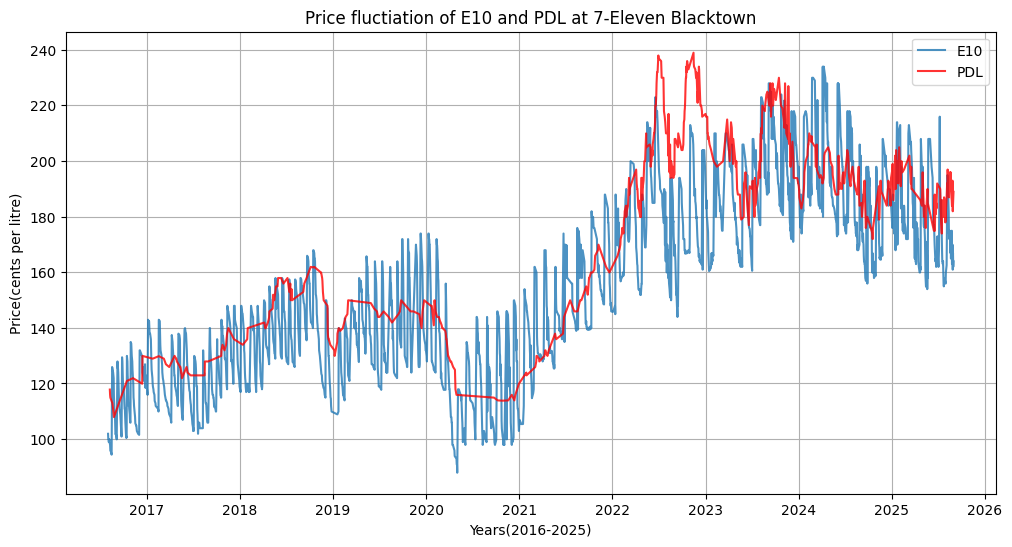

In [6]:
# choose 2 Fuel codes E10 and PDL for 7-Eleven Blacktown
SevenEleven = station_daily_df[station_daily_df['ServiceStationName'] == '7-Eleven Blacktown']

# find out the different types of fuels offered by 7-Eleven Blacktown 
fuels_sold = SevenEleven['FuelCode'].unique()
print("Fuels offered at 7-Eleven Blacktown",fuels_sold)

SevenEleven1 = SevenEleven[SevenEleven['FuelCode'] == 'E10']
SevenEleven2 = SevenEleven[SevenEleven['FuelCode'] == 'PDL']

plt.figure(figsize=(12,6))
plt.plot(SevenEleven1['PriceUpdatedDate'] , SevenEleven1['Price'] , label = "E10" , alpha = 0.8)
plt.plot(SevenEleven2['PriceUpdatedDate'] , SevenEleven2['Price'] ,  color = "red" , label = "PDL" , alpha = 0.8)
plt.xlabel("Years(2016-2025)")
plt.ylabel("Price(cents per litre)")
plt.legend()
plt.title(f"Price fluctiation of E10 and PDL at 7-Eleven Blacktown")
plt.grid(visible=True)
plt.show()





Distribution 

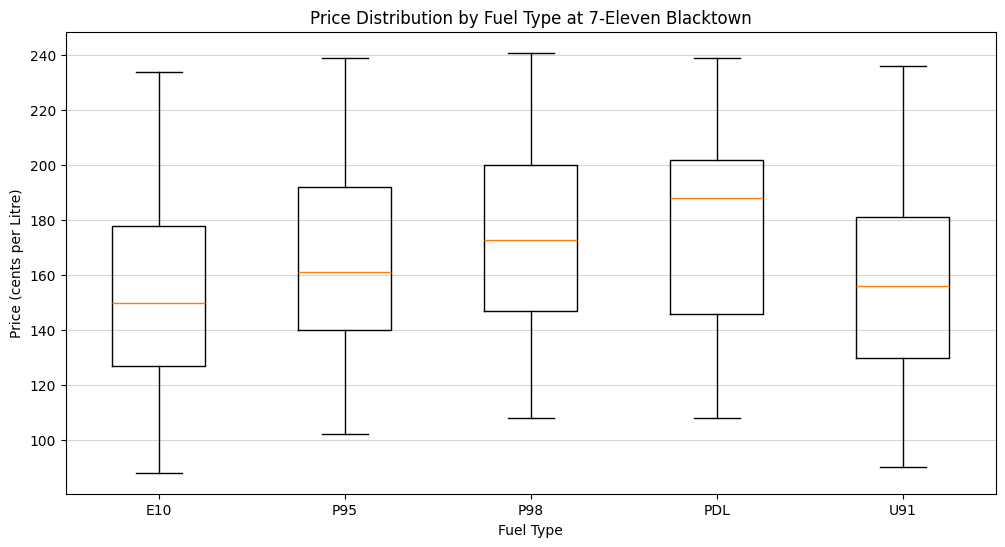

In [7]:
# show box plots comparing daily price across all available fuel codes 
# store each fuel code data
fuel_code_data = []
for fuels in fuels_sold:
    #filter dataframe for just the one fuel code 
    prices = SevenEleven[SevenEleven['FuelCode'] == fuels]['Price']
    #append into the array
    fuel_code_data.append(prices)

plt.figure(figsize=(12,6))
plt.boxplot(fuel_code_data, tick_labels=fuels_sold, patch_artist=False)
#titles and labels
plt.title("Price Distribution by Fuel Type at 7-Eleven Blacktown")
plt.xlabel("Fuel Type")
plt.ylabel("Price (cents per Litre)")
plt.grid(True, axis='y', alpha=0.5)
plt.show()


## Q1.2 - Forecasting Next-Day Prices
Build a one-step-ahead forecaster that, for each FuelCode and Fuel Station,
predicts the next day’s price using only information available up to the current
day. Formally, learn a function $$ y^{hat(c,s)}_{d+1}  = f_{c,s}(H^{c,s}_d) $$
where c indexes fuel codes, s represents fuel station and $H^{c}_d$
is the historical
data for fuel c up to day d.

### Q1.2(i) - Problem setup & data split **[2 marks]**
Define your forecasting setup clearly (inputs, target, and unit of time). Choose
and justify a train/validation/test partition suitable for time-ordered data. Describe how you prevent any information leakage from the future into training.

In [8]:
# target(y)  is the price of the fuel at the next day (d+1)
# input (X)  is the prices from day d all the way to day 0 (d-1 , d-2 , d-3 etc)
# Unit of time would be daily as thats how the data is stored 

# training data jan 2016 -  dec 2022
# validation data jan 2023 - dec 2023
# testing data   jan 2025 - Nov 2025#
# ensure no overlap to prevent leaky data which can bias training 

# ensure there isnt full random training here as we dont want data from 2024 to be training and data from 2022 to be testing. Create the splits of testing 

# create cutoff dates 
val_start_date = pd.Timestamp('2023-01-01')
test_start_date = pd.Timestamp('2024-01-01')

#create boolean masks
train_mask = station_daily_df['PriceUpdatedDate'] < val_start_date
val_mask = (station_daily_df['PriceUpdatedDate'] >= val_start_date) & (station_daily_df['PriceUpdatedDate'] < test_start_date)
test_mask = station_daily_df['PriceUpdatedDate'] >= test_start_date
# would need to specify the stations so that data sets dont contain all stations when forecasting for one specific station 
# This mask dosent actually work since it will include every station instead of just 7 eleven blacktown 

# generate new dataframes (use copy so that the original df isnt affected)
train_df = station_daily_df[train_mask].copy()
val_df = station_daily_df[val_mask].copy()
test_df = station_daily_df[test_mask].copy()
print("Original df shape", station_daily_df.shape)
print(f"Training Set:   {len(train_df)} rows ({train_df['PriceUpdatedDate'].min().date()} to {train_df['PriceUpdatedDate'].max().date()})")
print(f"Validation Set: {len(val_df)} rows ({val_df['PriceUpdatedDate'].min().date()} to {val_df['PriceUpdatedDate'].max().date()})")
print(f"Test Set:       {len(test_df)} rows ({test_df['PriceUpdatedDate'].min().date()} to {test_df['PriceUpdatedDate'].max().date()})")
 


Original df shape (38856, 4)
Training Set:   29234 rows (2016-08-01 to 2022-12-31)
Validation Set: 3530 rows (2023-01-01 to 2023-12-31)
Test Set:       6092 rows (2024-01-01 to 2025-08-31)


### Q1.2(ii) - Model design & training **[2 marks]**
Design one forecasting pipeline and apply it to the data. You may use any
models covered in or outside the course. Document all choices (features you
construct, model family, key hyperparameters) and your training procedure.

In [9]:
# model options - linear regression, random forest, neural networks, MLP, SVM

In [23]:
# create a function that takes a station dataset and desired fuel code and forecasts based off that 
def forecast_data (station_df , fuel_code):
    station_name = station_df['ServiceStationName'].iloc[0]
    print(f"Processing fuel code {fuel_code} for station {station_name}")
    
    #sort data to specific fuel code 
    target_mask = station_df['FuelCode'] == fuel_code
    target_df = station_df[target_mask].copy()
    
    #sort data by date 
    target_df = target_df.sort_values('PriceUpdatedDate')
    
    #create lags (previous values )
    num_lags = 7
    feature_cols = []
    for i in range(1, num_lags + 1):
        col_name = f'Lag_{i}'
        target_df[col_name] = target_df['Price'].shift(i)
        feature_cols.append(col_name)
    #remove nan data
    target_df = target_df.dropna()
    

    X = target_df[feature_cols]
    y = target_df['Price']
    dates = target_df['PriceUpdatedDate']
    #create boolean masks (recreate since needed specifically for station and all dates shifted back by 7)
    train_mask = target_df['PriceUpdatedDate'] < val_start_date
    val_mask = (target_df['PriceUpdatedDate'] >= val_start_date) & (target_df['PriceUpdatedDate'] < test_start_date)
    test_mask = target_df['PriceUpdatedDate'] >= test_start_date
    #using the masks to create sets 
    X_train, y_train = X[train_mask] , y[train_mask]
    X_val , y_val    = X[val_mask]   , y[val_mask]
    X_test , y_test  = X[test_mask]  , y[test_mask]
    
    # use and trial differnt models
    
    #model = LinearRegression()
    model = RandomForestRegressor(n_estimators=120, max_depth=10, random_state=42)   #random forest
    #model = GradientBoostingRegressor(n_estimators=120, learning_rate=0.1, max_depth=5, random_state=42)  # GradientBoostingRegressor
    #model = make_pipeline(StandardScaler(), SVR(C=100, epsilon=0.1))   #SVM

    #train model
    model.fit(X_train,y_train)

    # validation predictions
    if len(X_val) > 0:
        val_preds = model.predict(X_val)
        # error metrics 
        val_mse = mean_squared_error(y_val, val_preds)
        val_rmse = root_mean_squared_error(y_val,val_preds)
        sd = target_df['Price'].std()
        print(f"Validation Check | Validation MSE: {val_mse:.2f} | Validation RMSE: {val_rmse:.2f} | stnd dev: {sd:.2f}")
    else:
        print("Warning: No validation data available.")
    
    # test predictions
    if len(X_test) > 0:
        # predict new values 
        test_preds = model.predict(X_test)
        #calculate error metrics 
        mse = mean_squared_error(y_test, test_preds)
        rmse = root_mean_squared_error(y_test , test_preds)
        sd = target_df['Price'].std()
        print(f"Model Trained | Test MSE: {mse:.2f} | Test RMSE: {rmse:.2f} | stnd dev: {sd:.2f}")
    else:
        print("Warning: No data available for the Test period (2024+).")
        return model

    # output forecasted data 
    last_known_data = X.iloc[[-1]] 
    next_day_price = model.predict(last_known_data)[0]
    last_date = dates.iloc[-1].date()
    print(f"Last Date in Data: {last_date} with price: {y.iloc[-1]:.2f}")
    print(f"Forecast for Next Day: {next_day_price:.2f} cents")
    
    # plot data 
    plt.figure(figsize=(12,6))
    plt.plot(dates[test_mask], y_test , label = "Actual" , alpha = 0.8)
    plt.plot(dates[test_mask] , test_preds ,  color = "red" , label = "Predicted" , alpha = 0.8)
    plt.xlabel("Years(2024-2025)")
    plt.ylabel("Price(cents per litre)")
    plt.legend()
    plt.title(f"Forecasting Actual vs Prediction for {fuel_code} at {station_name}")
    plt.grid(visible=True)
    plt.show()

    if len(test_preds) > 0:
        test_dates = dates[test_mask]
        plot_df = pd.DataFrame({
            'Date': test_dates,
            'Actual': y_test,
            'Predicted': test_preds
        })
        # show last 3 months 
        last_90_days = plot_df.tail(90)
        
        plt.figure(figsize=(12, 6))
        plt.plot(last_90_days['Date'], last_90_days['Actual'], label="Actual Price", color='blue', marker='o', markersize=4, alpha=0.6)
        plt.plot(last_90_days['Date'], last_90_days['Predicted'], label="Forecast", color='red', linestyle='--', marker='x', markersize=4, linewidth=1.5)
        
        plt.title(f"Forecast for last 90 days: {station_name} ({fuel_code})")
        plt.xlabel("Years (2025)")
        plt.ylabel("Price (cents per litre)")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return model
    



# document choices 
# - features constructed - 
# developed lags (1-7) which record weekly fluctuations. used to allow model to see previous prices. Couldnt just look at day before as a larger span of historical data will benefit more 
# experiemented with linear regression and Random forest. forest perfomed better (record stats for both for report) 
# key hyperparamenters - set lag time as 7 days. talkd about random forest values used. estimators, depth, state
# training procedure was preparing data by including 7 lag values. to prevent leakage, used a validation set and chronological split. Validation allowed to check model was not overfitting to train/test data
# talk about mse and rmse values and what they mean 



### (iii) Evaluation & visualization **[2 marks]**
Evaluate on the held-out test set and report it. Include one predicted vs.
actual line plot for any fuel and provide a brief (≤100 words) interpretation of
typical errors and any noticeable patterns.

Processing fuel code E10 for station 7-Eleven Blacktown
Validation Check | Validation MSE: 128.15 | Validation RMSE: 11.32 | stnd dev: 31.69
Model Trained | Test MSE: 142.35 | Test RMSE: 11.93 | stnd dev: 31.69
Last Date in Data: 2025-08-31 with price: 163.90
Forecast for Next Day: 163.10 cents


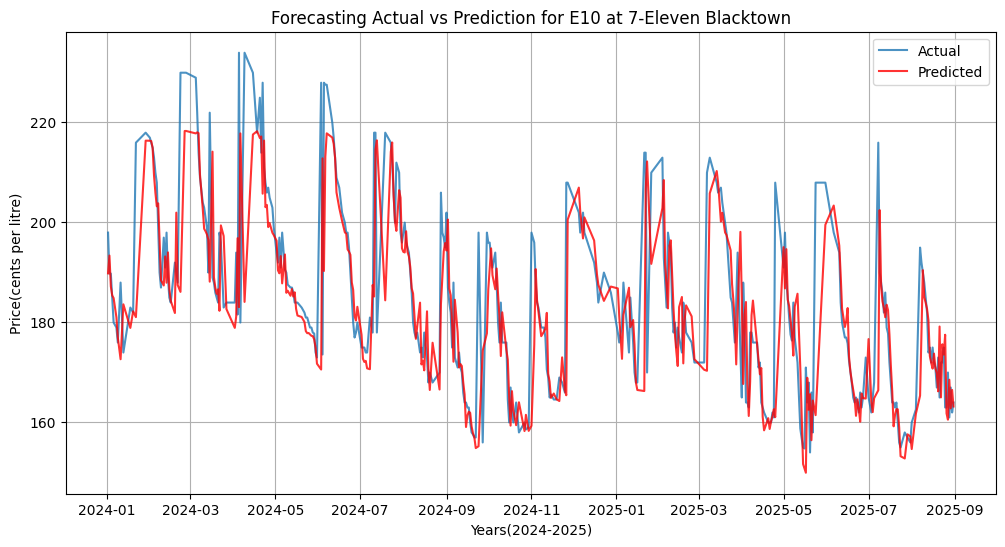

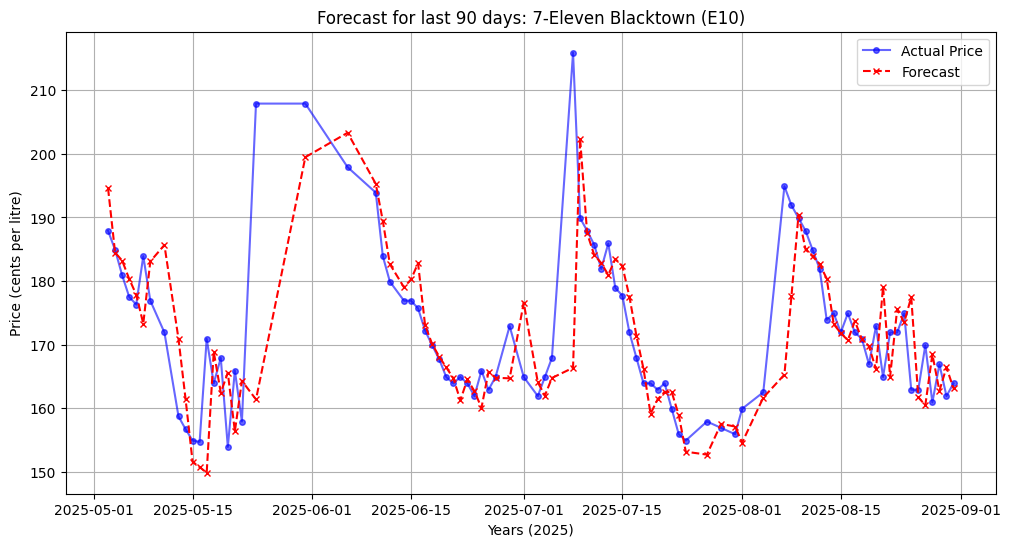

Mean value:  153.0831265508685
Processing fuel code U91 for station 7-Eleven Blacktown
Validation Check | Validation MSE: 124.91 | Validation RMSE: 11.18 | stnd dev: 31.90
Model Trained | Test MSE: 140.93 | Test RMSE: 11.87 | stnd dev: 31.90
Last Date in Data: 2025-08-31 with price: 165.90
Forecast for Next Day: 167.09 cents


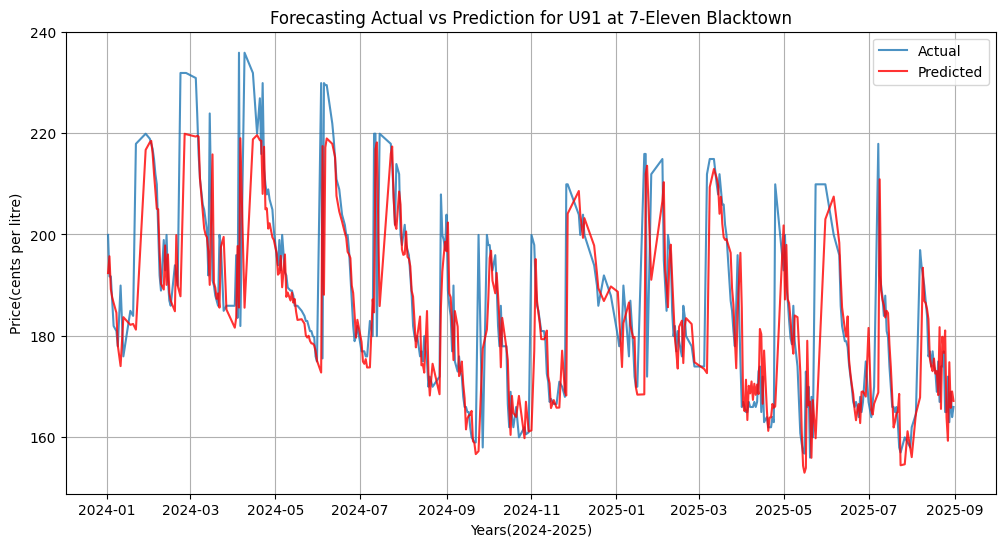

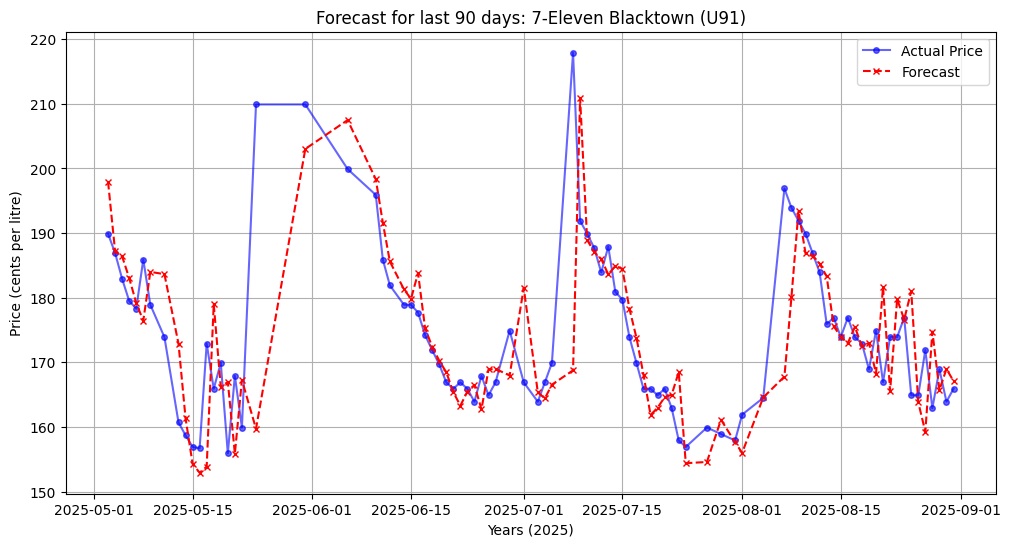

Processing fuel code P95 for station 7-Eleven Blacktown
Validation Check | Validation MSE: 125.47 | Validation RMSE: 11.20 | stnd dev: 32.10
Model Trained | Test MSE: 166.51 | Test RMSE: 12.90 | stnd dev: 32.10
Last Date in Data: 2025-08-31 with price: 179.90
Forecast for Next Day: 183.86 cents


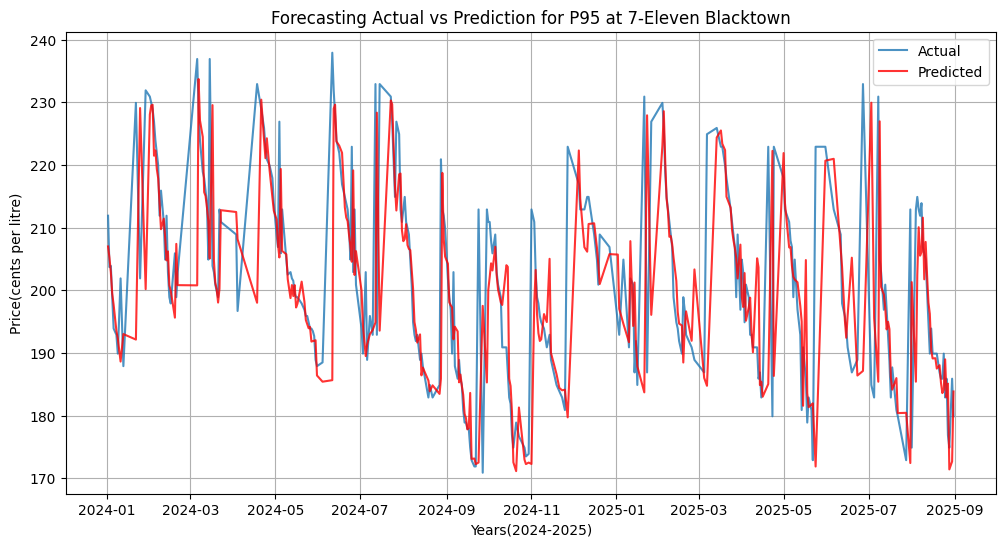

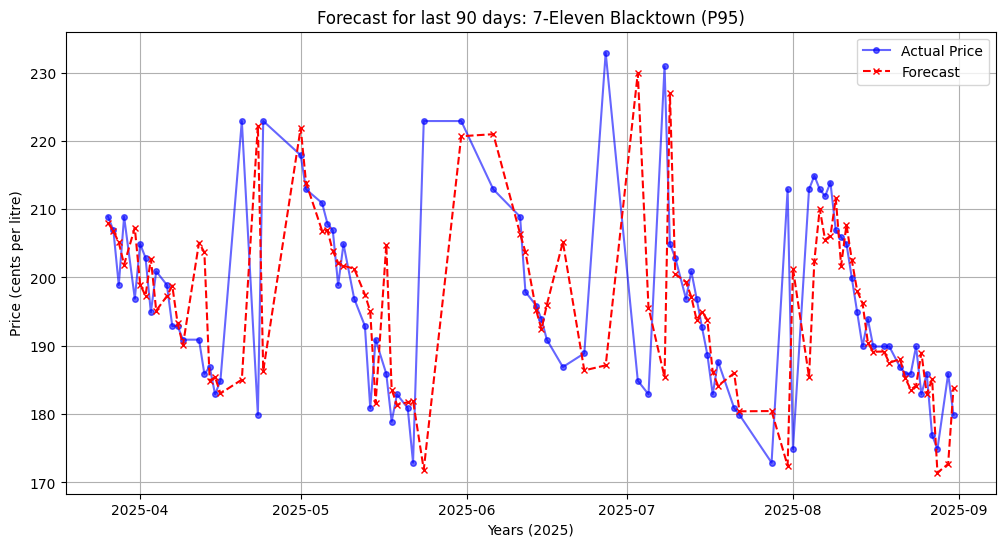

Processing fuel code P98 for station 7-Eleven Blacktown
Validation Check | Validation MSE: 108.63 | Validation RMSE: 10.42 | stnd dev: 32.38
Model Trained | Test MSE: 122.07 | Test RMSE: 11.05 | stnd dev: 32.38
Last Date in Data: 2025-08-31 with price: 185.90
Forecast for Next Day: 187.70 cents


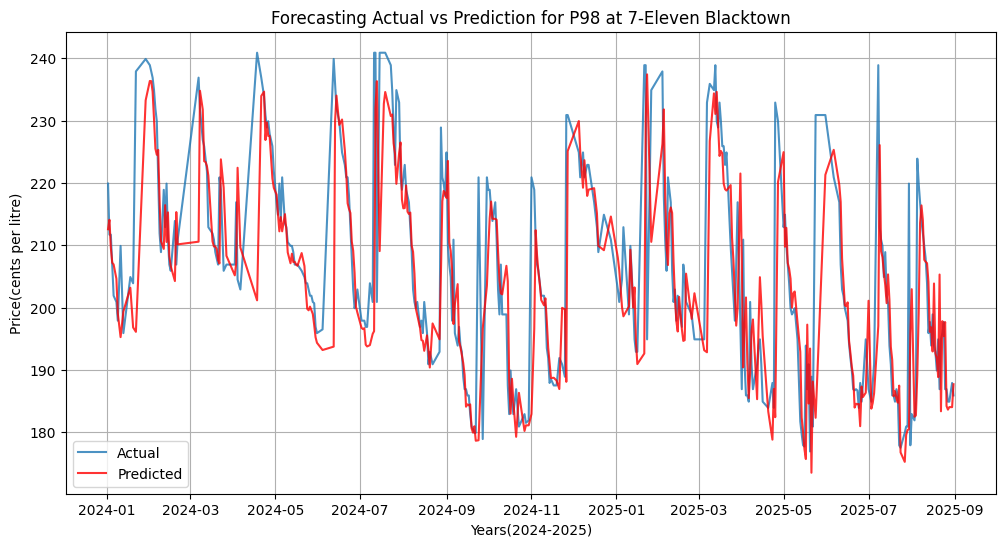

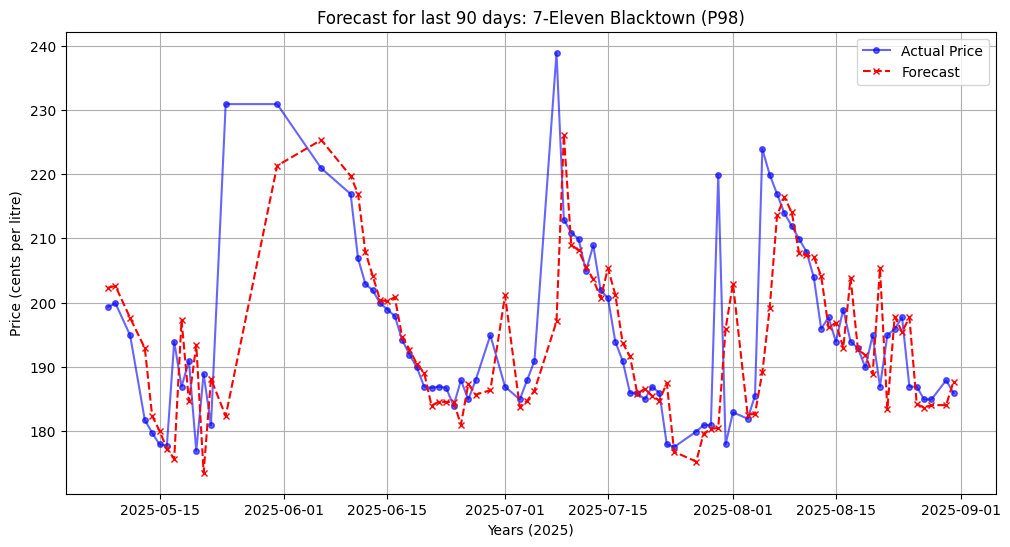

Processing fuel code PDL for station 7-Eleven Blacktown
Validation Check | Validation MSE: 48.04 | Validation RMSE: 6.93 | stnd dev: 33.39
Model Trained | Test MSE: 38.46 | Test RMSE: 6.20 | stnd dev: 33.39
Last Date in Data: 2025-08-31 with price: 188.90
Forecast for Next Day: 187.43 cents


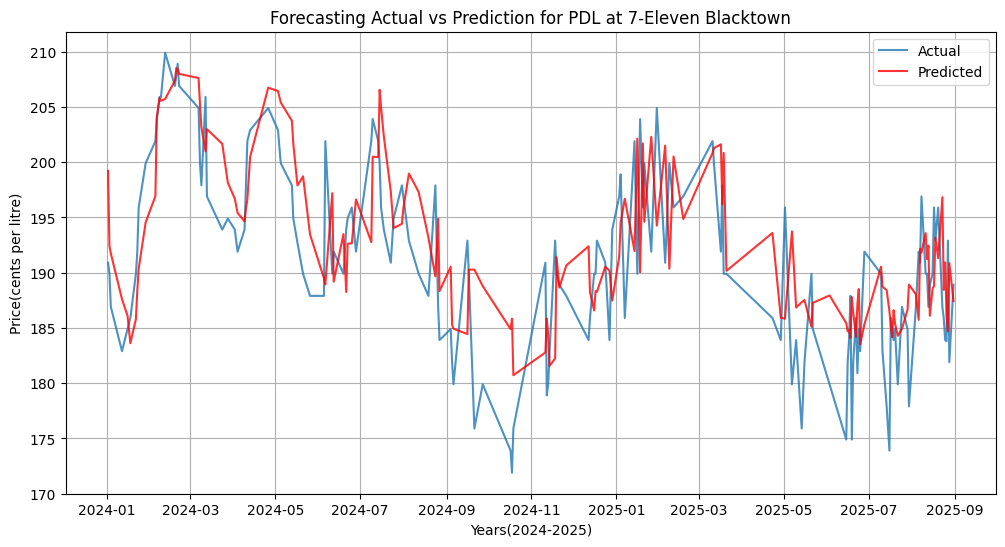

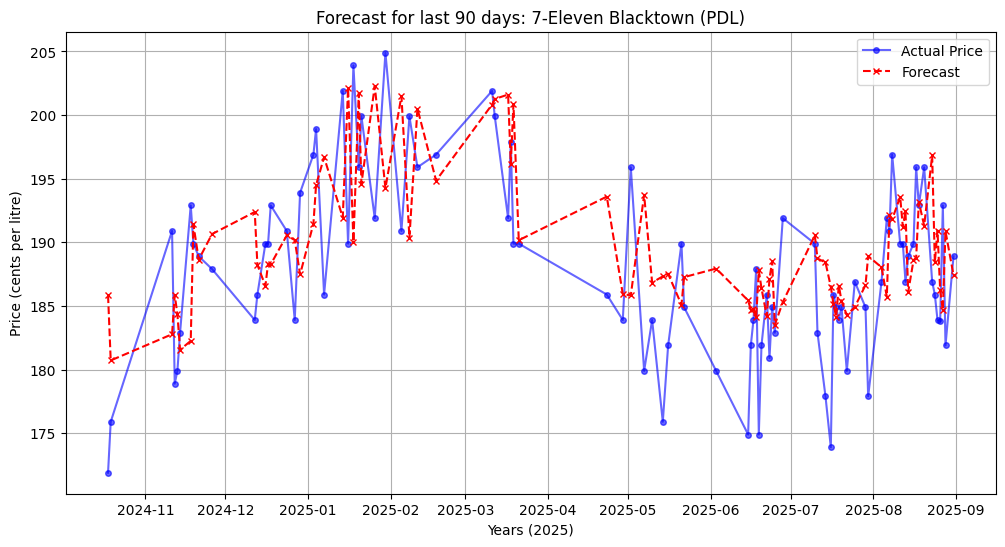

,n_estimators,120
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
# calling the function 
#test it on 7 eleven blacktown  
forecast_data(SevenEleven,"E10")
E10 = SevenEleven[SevenEleven['FuelCode'] == 'E10']

#gather some extra metrics 
e10mean = E10['Price'].mean()
print("Mean value: ", e10mean )

#test with other fuels

forecast_data(SevenEleven,"U91")
forecast_data(SevenEleven,"P95")
forecast_data(SevenEleven,"P98")
forecast_data(SevenEleven,"PDL")

In [12]:
#observation from this plot
#model stuggles to follow the rising prices. however accurately predicts the falling prices. Overall good generalisation to the data 
# training data and training has done a good job 
# in the zoomed in figure, rf struggles when there are lots of changes within a small timespan 

## Q1.3 - Applications and Limitations 


### Q1.3(i) - Practical use 
Hypothetically, explain how one could use your model to get the cheapest fuel
(could be any fuel code) if they must buy fuel every day **[1 mark]**

- The forecasting function can be implemented into a mobile application that allows customers to view the current fuel prices. If the prediction states that the price will go up the next day, the customer should fill up with fuel today. On the other hand, the the forecasted price drops, the customer should go fill up on fuel the next day.

### Q1.3(ii) - Limitation & Remedy 
Identify one key limitation of your current forecasting system (e.g., in data,
features, model, or evaluation). In ≤150 words, explain how you would address it, what change you would make, and how you would measure whether it
improved performance.**[1 mark]**

- The model relies exclusively on historical lag features, resulting in a 'reactive' behavior where predictions lag behind sharp trend reversals. It fails to anticipate sudden price shocks caused by external market forces.
- To remedy this, one could incorporate variables such as global oil prices. These are more likely to change before fuel station prices can be affected. This would benefit the algorithm as it would be given a sort of "heads up" that prices are going to rise
- To verify this implemented change, retrain the model with the new feature and compare the new MSE with the baseline. A reduction in MSE and consequently RMSE would suggest an improvement. However, make sure a validation set is being used as we dont want to be overfitting to the test data 